# Part 2 - Transfer learning Bees vs Ants

This tutorial converts the pure PyTorch approach described in [PyTorch's Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) to `skorch`

## Download data

In [1]:
%matplotlib inline

import os
from urllib import request
from zipfile import ZipFile
import matplotlib.pyplot as plt

In [2]:
def download_and_extract_data(dataset_dir='data'):
    data_zip = os.path.join(dataset_dir, 'hymenoptera_data.zip')
    data_path = os.path.join(dataset_dir, 'hymenoptera_data')
    url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"

    if not os.path.exists(data_path):
        if not os.path.exists(data_zip):
            print("Starting to download data...")
            data = request.urlopen(url, timeout=15).read()
            with open(data_zip, 'wb') as f:
                f.write(data)

        print("Starting to extract data...")
        with ZipFile(data_zip, 'r') as zip_f:
            zip_f.extractall(dataset_dir)
        
    print("Data has been downloaded and extracted to {}.".format(dataset_dir))
    
download_and_extract_data()

Data has been downloaded and extracted to data.


## Explore Data

In [3]:
from glob import glob
from PIL import Image

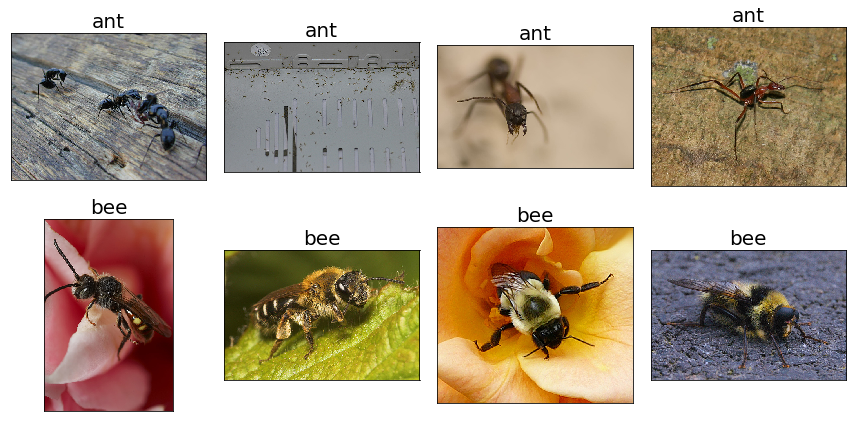

In [4]:
data_dir = 'data/hymenoptera_data'

ant_image_fns = glob(os.path.join(data_dir, "train/ants/*"))[4:8]
bee_image_fns = glob(os.path.join(data_dir, "train/bees/*"))[4:8]
all_image_fns = [('ant', fn) for fn in  ant_image_fns] + [('bee', fn) for fn in bee_image_fns]

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for (label, fn), ax in zip(all_image_fns, axes.flatten()):
    img = Image.open(fn)
    ax.set_title(label, fontsize=20)
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
fig.savefig("images/bee_vs_ant_images.jpg")

## Using torchvision

In [6]:
!tree data/hymenoptera_data/ -L 2

data/hymenoptera_data/
├── train
│   ├── ants
│   └── bees
└── val
    ├── ants
    └── bees

6 directories, 0 files


In [7]:
import torchvision.transforms as tfms
from torchvision.datasets import ImageFolder

train_tfms = tfms.Compose([
    tfms.RandomResizedCrop(224),
    tfms.RandomHorizontalFlip(),
    tfms.ToTensor(),
    tfms.Normalize([0.485, 0.456, 0.406], 
                   [0.229, 0.224, 0.225])
])

train_ds = ImageFolder(
    os.path.join(data_dir, "train") , train_tfms
)

In [9]:
val_tfms = tfms.Compose([
    tfms.RandomResizedCrop(256),
    tfms.CenterCrop(224),
    tfms.ToTensor(),
    tfms.Normalize([0.485, 0.456, 0.406], 
                   [0.229, 0.224, 0.225])
])

val_ds = ImageFolder(
    os.path.join(data_dir, "val"), val_tfms,)

In [80]:
len(train_ds), len(val_ds)

(244, 153)

In [82]:
img, target = train_ds[0]

In [86]:
img.shape, target

(torch.Size([3, 224, 224]), 0)

In [88]:
train_ds.class_to_idx

{'ants': 0, 'bees': 1}

## Pretrained model

In [10]:
from torchvision.models import resnet18
import torch.nn as nn

class PretrainedModel(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.model_ft = resnet18(pretrained=pretrained)
        num_ftrs = self.model_ft.fc.in_features
        self.model_ft.fc = nn.Linear(num_ftrs, 2)
        
    def forward(self, X):
        return self.model_ft(X)

## Skorch callbacks

## Freezer

In [11]:
from skorch.callbacks import Freezer

freezer = Freezer(lambda x: not x.startswith('model_ft.fc'))

### LRScheduler

In [12]:
from skorch.callbacks import LRScheduler

lr_scheduler = LRScheduler(
    policy='StepLR', step_size=7, gamma=0.1
)

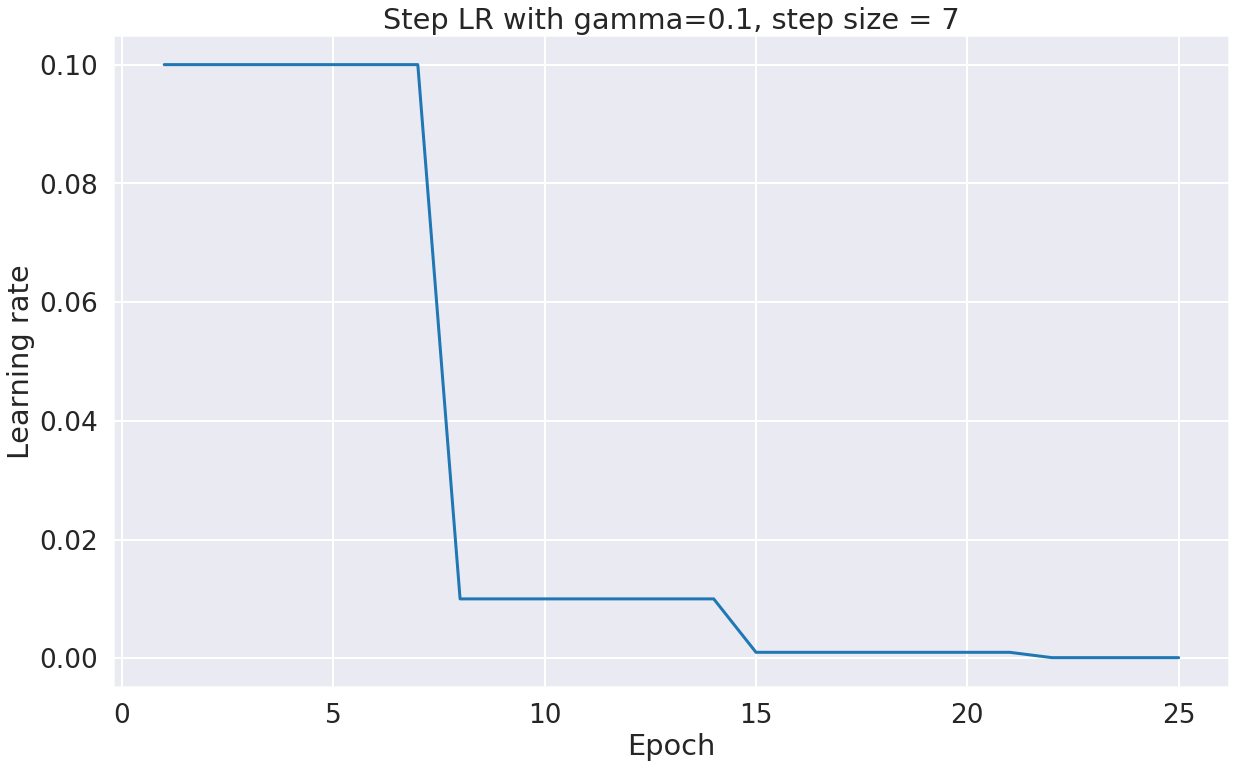

In [26]:
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('poster', font_scale=1.2)

max_epochs = 25
epochs = np.arange(1, max_epochs+1)
lrs = lr_scheduler.simulate(max_epochs, initial_lr=0.1)

fig, ax = plt.subplots(figsize=(20, 12))
fig.patch.set_alpha(0)
ax.set_title("Step LR with gamma=0.1, step size = 7")
ax.set_ylabel("Learning rate")
ax.set_xlabel("Epoch")
_ = ax.plot(epochs, lrs)
fig.savefig("images/step_lr.png")

### EpochScoring

In [13]:
from sklearn.metrics import accuracy_score, make_scorer
from skorch.callbacks import EpochScoring

def accuracy_argmax(y_true, y_pred):
    return accuracy_score(y_true, np.argmax(y_pred, -1))
accuracy_argmax_scorer = make_scorer(accuracy_argmax)

epoch_acc = EpochScoring(
    accuracy_argmax_scorer,
    name='valid_acc',
    lower_is_better=False)

## Checkpoint

In [14]:
from skorch.callbacks import Checkpoint

checkpoint = Checkpoint(
    dirname="exp_01_bee_vs_ant", monitor="valid_acc_best")

## TrainEndCheckpoint

In [15]:
from skorch.callbacks import TrainEndCheckpoint

train_end_cp = TrainEndCheckpoint(
    dirname="exp_01_bee_vs_ant", fn_prefix="train_end_")

## skorch NeutralNet

In [17]:
from skorch import NeuralNet
import torch.nn as nn
import torch.optim as optim
from skorch.helper import predefined_split

net = NeuralNet(
    PretrainedModel,
    criterion=nn.CrossEntropyLoss,
    lr=0.001,
    batch_size=4,
    max_epochs=10,
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True,
    iterator_train__num_workers=4,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=4,
    train_split=predefined_split(val_ds),
    callbacks=[freezer, lr_scheduler, epoch_acc, checkpoint, train_end_cp],
    device='cuda' # comment to train on cpu
)

In [72]:
_ = net.fit(train_ds)

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        0.5843       0.8431        0.3255     +  0.8880
      2        0.4494       0.8039        0.4183        0.9038
      3        0.4476       0.9346        0.2138     +  0.9654
      4        0.4246       0.6928        0.7160        0.9082
      5        0.5420       0.8758        0.2649        0.9379
      6        0.5066       0.9346        0.1583        0.9024
      7        0.5228       0.9085        0.2185        0.9497
      8        0.3358       0.9085        0.1763        0.9702
      9        0.3002       0.8824        0.2365        0.9347
     10        0.3740       0.9216        0.1750        0.9728


In [73]:
!tree exp_01_bee_vs_ant/

exp_01_bee_vs_ant/
├── history.json
├── optimizer.pt
├── params.pt
├── train_end_history.json
├── train_end_optimizer.pt
└── train_end_params.pt

0 directories, 6 files


In [74]:
net.load_params(checkpoint=checkpoint)
val_output = net.predict(val_ds)

Re-initializing module because the following parameters were re-set: .
Re-initializing optimizer because the following parameters were re-set: lr, momentum.


In [79]:
print(val_output.shape)

(153, 2)


In [75]:
val_ds.class_to_idx

{'ants': 0, 'bees': 1}

In [76]:
net.load_params(checkpoint=train_end_cp)

Re-initializing module because the following parameters were re-set: .
Re-initializing optimizer because the following parameters were re-set: lr, momentum.


In [78]:
net.set_params(max_epochs=5)
_ = net.partial_fit(train_ds)

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
     11        0.3355       0.9346        0.1940        1.4313
     12        0.3478       0.9020        0.2325        1.4029
     13        0.3264       0.9216        0.2454        1.3923
     14        0.3108       0.9216        0.1957        1.4313
     15        0.2589       0.9412        0.1617     +  1.3786


## Saving and loading

In [16]:
from skorch.callbacks import LoadInitState

def run(max_epochs):
    checkpoint = Checkpoint(
        dirname="exp_02_bee_vs_ant", monitor="valid_acc_best")
    train_end_cp = TrainEndCheckpoint(
        dirname="exp_02_bee_vs_ant", fn_prefix="train_end_")
    load_state = LoadInitState(train_end_cp)

    net = NeuralNet(
        PretrainedModel,
        criterion=nn.CrossEntropyLoss,
        lr=0.001,
        batch_size=4,
        max_epochs=max_epochs,
        optimizer=optim.SGD,
        optimizer__momentum=0.9,
        iterator_train__shuffle=True,
        iterator_train__num_workers=4,
        iterator_valid__shuffle=False,
        iterator_valid__num_workers=4,
        train_split=predefined_split(val_ds),
        callbacks=[freezer, lr_scheduler, epoch_acc, 
                   checkpoint, train_end_cp, load_state],
        device='cuda' # comment to train on cpu
    ).fit(train_ds)

In [55]:
# First run
run(max_epochs=10)

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        0.6188       0.9020        0.2668     +  0.8765
      2        0.4643       0.9150        0.2292     +  0.9142
      3        0.4961       0.8497        0.3350        0.8922
      4        0.5032       0.9216        0.1880     +  0.9797
      5        0.3633       0.9542        0.1523     +  0.9335
      6        0.4452       0.9085        0.2150        0.9266
      7        0.5123       0.9216        0.1864        0.9245
      8        0.3044       0.9216        0.2392        0.9024
      9        0.3180       0.9150        0.2242        0.9521
     10        0.3799       0.9412        0.2020        0.9019


In [56]:
# Second run
run(max_epochs=5)

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
     11        0.3276       0.9020        0.1997     +  1.3941
     12        0.3745       0.9281        0.2342     +  1.3842
     13        0.3290       0.9412        0.1929     +  1.3865
     14        0.3600       0.9477        0.1832     +  1.3775
     15        0.2783       0.9346        0.2210        1.3629


In [19]:
# prediction
checkpoint = Checkpoint(
    dirname="exp_02_bee_vs_ant", monitor="valid_acc_best")
train_end_cp = TrainEndCheckpoint(
    dirname="exp_02_bee_vs_ant", fn_prefix="train_end_")
load_state = LoadInitState(train_end_cp)

net = NeuralNet(
    PretrainedModel,
    criterion=nn.CrossEntropyLoss,
    lr=0.001,
    batch_size=4,
    max_epochs=10,
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True,
    iterator_train__num_workers=4,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=4,
    train_split=predefined_split(val_ds),
    callbacks=[freezer, lr_scheduler, epoch_acc, 
               checkpoint, train_end_cp, load_state],
    device='cuda' # comment to train on cpu
)

net.initialize()
net.load_params(checkpoint=checkpoint)

In [35]:
X = val_ds[0][0][None, :]
print(X.shape)

torch.Size([1, 3, 224, 224])


In [38]:
X_numpy = val_ds[0][0].numpy()[None, :]

In [40]:
X_numpy.shape

(1, 3, 224, 224)

In [43]:
X_pred = net.predict(X_numpy)

In [47]:
X_pred

array([[-0.44090486,  0.1810616 ]], dtype=float32)

In [45]:
import numpy as np
np.exp(X_pred)/(1+np.exp(X_pred))

array([[0.3915254, 0.5451421]], dtype=float32)

In [28]:
val_pred = net.predict(val_ds)

In [34]:
net.predict(X)

array([[ 0.35997406, -0.41962692]], dtype=float32)

In [29]:
val_pred.shape

(153, 2)